I think after a rough period, we finally might have the complete results to understand the importance of having a consistent metric across embedding and clustering methods and also the importance of the choice of metric itself.

We have results for embeddings generated from Node2Vec with Dot similarity (default), Cosine similarity and Euclidan Distance, that are clustered using K-Means++ which uses Euclidean (default), dot similarity and cosine similarity.

We have 10,000 node LFR networks of increasing network density and mixing used to generate the embeddings and clustering. We also wish to change the dimension of the embeddings to see the differences there, but for today, we rest easy with this.

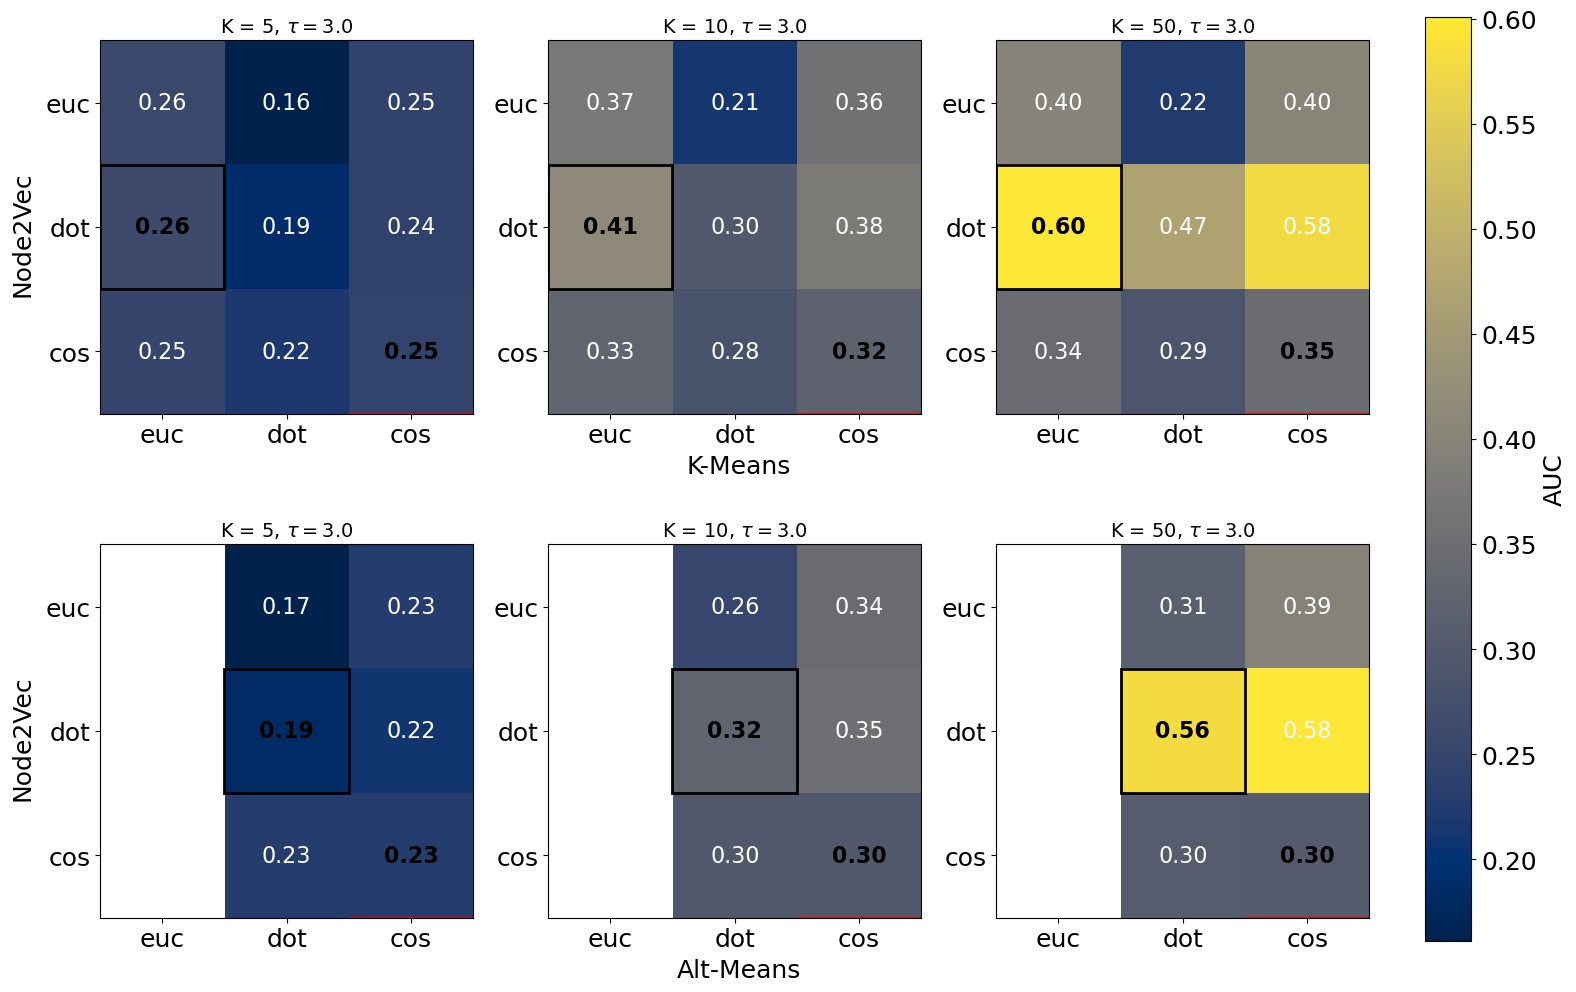

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# SETTINGS & STYLING
dims = [5, 10, 50]  # Network dimensions
embedding_types = ['euclidean', 'cosine', 'dot']
score_keys = ['kmeans++', 'kmeans_euclidean', 'kmeans_dot', 'kmeans_cosine']
score_label_map = {
    'kmeans++': '++',
    'kmeans_euclidean': 'euc',
    'kmeans_dot': 'dot',
    'kmeans_cosine': 'cos'
}
embed_short = {'euclidean': 'euc', 'cosine': 'cos', 'dot': 'dot'}
alt_score_label_map = {
    'altmeans_euclidean': 'euc',
    'altmeans_dot': 'dot',
    'altmeans_cosine': 'cos'
}

# Text and axis sizes.
text_size = 16
title_size = 14
axis_label_size = 18
tick_label_size = 18

# ------------------------------
# Helper functions to load & process data.
def load_clustering_data(dim, embed, kind='kmeans'):
    """
    Loads clustering data for a given dimension and embedding type.
    For embedding 'cosine', uses a different base path.
    'kind' is either 'kmeans' or 'altmeans'.
    """
    if kind == 'kmeans':
        if embed == 'cosine':
            base_path = f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_n2v_metric_cosine_change_10000_{dim}_3.0_minc50"
        else:
            base_path = f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_n2v_metric_change_10000_{dim}_3.0_minc50_immutable"
        file_path = os.path.join(base_path, f"n2v_{embed}_kmeans_clustering.txt")
    else:  # altmeans
        if embed == 'cosine':
            base_path = f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_n2v_metric_cosine_change_10000_{dim}_3.0_minc50"
        else:
            base_path = f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_n2v_metric_change_10000_{dim}_3.0_minc50_immutable"
        file_path = os.path.join(base_path, f"n2v_{embed}_altmeans_clustering.txt")
    
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}. Skipping {kind} for embedding '{embed}' and dim {dim}.")
        return None

    df = pd.read_csv(file_path, delimiter=',')
    
    if kind == 'altmeans':
        # Rename proposed columns.
        df.rename(columns={
            'proposed_euclidean': 'altmeans_euclidean',
            'proposed_cosine': 'altmeans_cosine',
            'proposed_dot': 'altmeans_dot'
        }, inplace=True)
        group_keys = ['altmeans_dot', 'altmeans_cosine']
    else:
        group_keys = score_keys

    # Group by 'mu' and compute mean and std.
    grouped = df.groupby('mu')[group_keys].agg(['mean', 'std']).reset_index()
    # Flatten MultiIndex columns.
    grouped.columns = ['_'.join(col).strip() if col[1] != '' else col[0]
                        for col in grouped.columns.values]
    return grouped

# ------------------------------
# Load K-Means and Alt-Means data.
data = {dim: {} for dim in dims}
alt_data = {dim: {} for dim in dims}

for dim in dims:
    for embed in embedding_types:
        df_k = load_clustering_data(dim, embed, kind='kmeans')
        if df_k is not None:
            data[dim][embed] = df_k

        df_alt = load_clustering_data(dim, embed, kind='altmeans')
        if df_alt is not None:
            alt_data[dim][embed] = df_alt

# ------------------------------
# Compute AUC values.
auc_kmeans = []
for dim in dims:
    for embed in embedding_types:
        if embed not in data[dim]:
            continue
        df = data[dim][embed]
        for sk in score_keys:
            mean_col = f"{sk}_mean"
            if mean_col not in df.columns:
                continue
            auc = np.trapz(df[mean_col], df['mu'])
            # Mark consistency.
            if (embed == 'euclidean' and sk == 'kmeans_euclidean') or \
               (embed == 'cosine' and sk == 'kmeans_cosine') or \
               (embed == 'dot' and sk == 'kmeans_dot'):
                consistency = 'consistent'
            else:
                consistency = 'inconsistent'
            auc_kmeans.append({
                'dim': dim,
                'embed': embed,
                'score_key': sk,
                'auc': auc,
                'consistency': consistency,
                'curve_label': f"{embed_short[embed]}-{score_label_map[sk]}"
            })
df_kmeans = pd.DataFrame(auc_kmeans)

auc_alt = []
for dim in dims:
    for embed in embedding_types:
        if embed not in alt_data[dim]:
            continue
        df_alt = alt_data[dim][embed]
        for ask in alt_score_label_map.keys():
            mean_col = f"{ask}_mean"
            if mean_col not in df_alt.columns:
                continue
            auc = np.trapz(df_alt[mean_col], df_alt['mu'])
            if (embed == 'euclidean' and ask == 'altmeans_euclidean') or \
               (embed == 'cosine' and ask == 'altmeans_cosine') or \
               (embed == 'dot' and ask == 'altmeans_dot'):
                consistency = 'consistent'
            else:
                consistency = 'inconsistent'
            auc_alt.append({
                'dim': dim,
                'embed': embed,
                'alt_score_key': ask,
                'auc': auc,
                'consistency': consistency,
                'curve_label': f"{embed_short[embed]}-{alt_score_label_map[ask]}"
            })
df_alt = pd.DataFrame(auc_alt)

# ------------------------------
# Plotting.
row_order = ['euclidean', 'dot', 'cosine']    # actual data order
row_labels = ['euc', 'dot', 'cos']              # displayed labels
col_order_means = ['kmeans_euclidean', 'kmeans_dot', 'kmeans_cosine']
col_order_alt = ['altmeans_euclidean', 'altmeans_dot', 'altmeans_cosine']
col_labels = ['euc', 'dot', 'cos']

# Global min and max for color scaling.
global_min_means = df_kmeans['auc'].min()
global_max_means = df_kmeans['auc'].max()
global_min_alt = df_alt['auc'].min()
global_max_alt = df_alt['auc'].max()

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

for j, dim in enumerate(dims):
    # --- Top row: K-Means heatmap.
    df_k_dim = df_kmeans[df_kmeans['dim'] == dim]
    pivot_means = df_k_dim.pivot(index='embed', columns='score_key', values='auc')
    pivot_means = pivot_means.reindex(index=row_order, columns=col_order_means)
    
    ax = axes[0, j]
    im = ax.imshow(pivot_means, vmin=global_min_means, vmax=global_max_means, cmap='cividis')
    ax.set_title(f"K = {dim}, $\\tau = 3.0$", fontsize=title_size)
    ax.set_xticks(np.arange(len(col_labels)))
    ax.set_xticklabels(col_labels, fontsize=tick_label_size)
    ax.set_yticks(np.arange(len(row_labels)))
    ax.set_yticklabels(row_labels, fontsize=tick_label_size)
    
    for i in range(len(row_order)):
        for k in range(len(col_order_means)):
            value = pivot_means.iloc[i, k]
            if pd.notna(value):
                # Use bold text in specific cells.
                if (i == 1 and k == 0) or (i == 2 and k == 2):
                    ax.text(k, i, f"{value:.2f}", ha="center", va="center",
                            color="black", fontsize=text_size, fontweight="bold")
                else:
                    ax.text(k, i, f"{value:.2f}", ha="center", va="center",
                            color="w", fontsize=text_size)
    
    # Example border patches.
    ax.add_patch(plt.Rectangle((-0.5, 0.5), 1, 1, fill=False, edgecolor='black', linewidth=2))
    ax.add_patch(plt.Rectangle((1.5, 2.5), 1, 1, fill=False, edgecolor='red', linewidth=2))
    
    # --- Bottom row: Alt-Means heatmap.
    df_a_dim = df_alt[df_alt['dim'] == dim]
    pivot_alt = df_a_dim.pivot(index='embed', columns='alt_score_key', values='auc')
    pivot_alt = pivot_alt.reindex(index=row_order, columns=col_order_alt)
    # For altmeans using euclidean, replace 0 with NaN.
    if 'altmeans_euclidean' in pivot_alt.columns:
        pivot_alt['altmeans_euclidean'] = pivot_alt['altmeans_euclidean'].replace(0, np.nan)
    
    ax2 = axes[1, j]
    im2 = ax2.imshow(pivot_alt, vmin=global_min_alt, vmax=global_max_alt, cmap='cividis')
    ax2.set_title(f"K = {dim}, $\\tau = 3.0$", fontsize=title_size)
    ax2.set_xticks(np.arange(len(col_labels)))
    ax2.set_xticklabels(col_labels, fontsize=tick_label_size)
    ax2.set_yticks(np.arange(len(row_labels)))
    ax2.set_yticklabels(row_labels, fontsize=tick_label_size)
    
    for i in range(len(row_order)):
        for k in range(len(col_order_alt)):
            value = pivot_alt.iloc[i, k]
            text = "N/A" if pd.isna(value) else f"{value:.2f}"
            if pd.notna(value) and ((i == 1 and k == 1) or (i == 2 and k == 2)):
                ax2.text(k, i, text, ha="center", va="center",
                         color="black", fontsize=text_size, fontweight="bold")
            else:
                ax2.text(k, i, text, ha="center", va="center",
                         color="w", fontsize=text_size)
    
    ax2.add_patch(plt.Rectangle((0.5, 0.5), 1, 1, fill=False, edgecolor='black', linewidth=2))
    ax2.add_patch(plt.Rectangle((1.5, 2.5), 1, 1, fill=False, edgecolor='red', linewidth=2))

# Remove individual axis labels.
for ax in axes.flat:
    ax.set_xlabel("")
    ax.set_ylabel("")

# Add overall labels.
fig.text(0.075, 0.70, "Node2Vec", va="center", rotation="vertical", fontsize=axis_label_size)
fig.text(0.075, 0.28, "Node2Vec", va="center", rotation="vertical", fontsize=axis_label_size)
fig.text(0.48, 0.5, "K-Means", ha="center", fontsize=axis_label_size)
fig.text(0.48, 0.08, "Alt-Means", ha="center", fontsize=axis_label_size)

# Single common colorbar.
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.05, pad=0.04)
cbar.set_label("AUC", fontsize=axis_label_size)
cbar.ax.tick_params(labelsize=tick_label_size)

save_path = "/nobackup/gogandhi/alt_means_sans_k/Figs/Draft/heatmaps.png"
# plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
